In [133]:
import numpy as np
import pandas as pd
import scipy.stats as stats

from LDA import LDA

import warnings
warnings.filterwarnings('ignore')

### Load data

In [2]:
data_train = np.load('data/fashion_train.npy', mmap_mode='r')
data_test = np.load('data/fashion_test.npy', mmap_mode='r')

In [3]:
X_train = data_train[:, :-1]
y_train = data_train[:, -1]

X_test = data_test[:, :-1]
y_test = data_test[:, -1]

In [4]:
clf = LDA(n_components=2)
clf.fit(X_train, y_train)

X_train_transformed = clf.transform(X_train)
X_test_transformed = clf.transform(X_test)

### Gaussian KDE

In [126]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

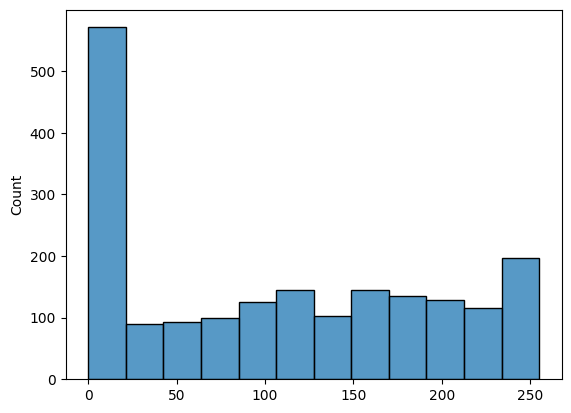

In [146]:
fig, ax = plt.subplots();

x=X_train[y_train==1][:,345]

sns.histplot(x);

In [147]:
kernel=stats.gaussian_kde(x.T)

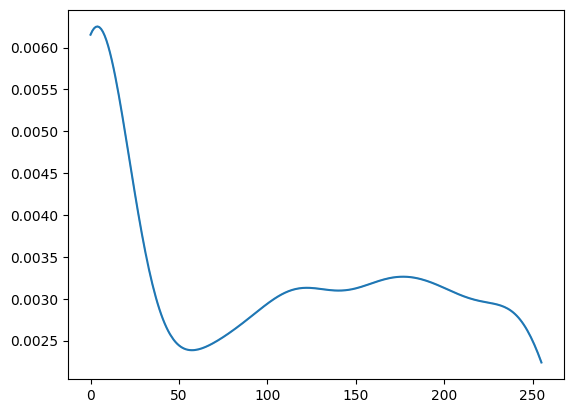

In [143]:
x1 = kernel.pdf(x)
sns.lineplot(x=x, y=x1);

### Build classifier

In [122]:
class NaiveBayes():
    def __init__(self, h, pdf_estimator):
        # User defined parameters
        self.h = h # Step size in histogram
        self.pdf_estimator = pdf_estimator # Type of pdf-estimator: hist or kde


        self.class_labels = None
        self.priors = None # Prior class probabilities
        self.conditionals = None # Class conditionals

    def get_params(self, deep=True):
        params = {'h': self.h, 'pdf_estimator': self.pdf_estimator}

        return params

    def pdf_hist(self, X, y, class_labels):
        conditionals = dict()

        for cl in class_labels:
            c = []
            for x in X[y == cl].T:
                bins = int(np.ceil((max(x)-min(x)) / self.h))
                d, upper_bound = np.histogram(x, bins=bins, density=True)

                c.append([[d, upper_bound] for d, upper_bound in zip(d, upper_bound)])

            conditionals[cl] = c

        return conditionals

    def pdf_kde(self, X, y, class_labels):
        '''
        Finds and saves kernel for each feature in each class.
        '''

        # Create dict to save kernels for each class
        kernels = dict()

        for cl in class_labels:
            # Create list to save kernels for each feature in each class
            kernels_cl = []

            for i in range(X.shape[1]):
                x = X[y == cl][:,i]
                
                kernels_cl.append(stats.gaussian_kde(x, self.h))
            
            kernels[cl] = kernels_cl

        # Save kernels
        self.kernels = kernels

    def fit(self, X, y):
        self.class_labels = np.unique(y)
        n = X.shape[0]

        # Prior class probabilities
        self.priors = {cl: sum(y==cl)/n for cl in self.class_labels}

        # Conditional probabilities
        if self.pdf_estimator == 'hist':
            self.conditionals = self.pdf_hist(X, y, self.class_labels)
        elif self.pdf_estimator == 'kde':
            self.kernel = self.pdf_kde(X, y, self.class_labels)
        else:
            'Type of pdf estimator is not available.'

    def pdf(self, cl, i, f):
        
        if self.pdf_estimator == 'kde':
            return self.kernels[cl][i].pdf(f)
        elif self.pdf_estimator == 'hist':
            for d, upper_bound in self.conditionals[cl][i]:
                if f < upper_bound:
                    return d
            return d

    def class_c_pdf(self, x, cl):
        class_conditionals = []
                    
        for i, f in enumerate(x):
            class_conditionals.append(self.pdf(cl, i, f))

        return class_conditionals

    def predict_proba(self, X):

        n, K = X.shape[0], len(self.priors)

        # For each sample compute the posterior probabilities for all classes           
        posteriors = np.empty((n, K))
        
        for i in range(n):
            
            # Likelihoods
            likelihoods = []
            for cl in self.class_labels:
                prior = self.priors[cl]

                class_conditionals = self.class_c_pdf(X[i], cl)
                likelihood = prior * np.prod(class_conditionals)
            
                likelihoods.append(likelihood)
                            
            # Normalize likelihoods to get posteriors
            posteriors[i] = likelihoods/np.sum(likelihoods)

        return posteriors

    def predict(self, X):

        posteriors = self.predict_proba(X)
        return np.argmax(posteriors, axis=1)

In [115]:
NB = NaiveBayes(0.2,'kde')
NB.fit(X_train_transformed, y_train)

In [116]:
yhat = NB.predict(X_test_transformed)

### Cross validation

In [125]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, make_scorer

In [ ]:
classifiers_hist = [NaiveBayes(h,'hist') for h in H]
classifiers_kde = [NaiveBayes(h,'kde') for h in H]

In [106]:
class

In [96]:
H = np.arange(start=0.1, stop=1.1, step=0.1)

In [107]:
scores ={'accuracy': make_scorer(accuracy_score), 
	  'sensitivity': make_scorer(recall_score), 
	  'specificity': make_scorer(recall_score, pos_label=0), 
	  'precision': make_scorer(precision_score), 
	  'roc_auc': make_scorer(roc_auc_score, needs_proba=True)}

### Test

In [48]:
from sklearn.metrics import accuracy_score

In [79]:
accuracy_score(y_true=y_test, y_pred=yhat)

0.727

In [76]:
10000**(-1./(2+4))

0.2154434690031884

### Visualization

In [134]:
d = {'LDA1':X_train_transformed[:,0], 'LDA2':X_train_transformed[:,1]}
X = pd.DataFrame(d)
y=y_train

NameError: name 'i' is not defined

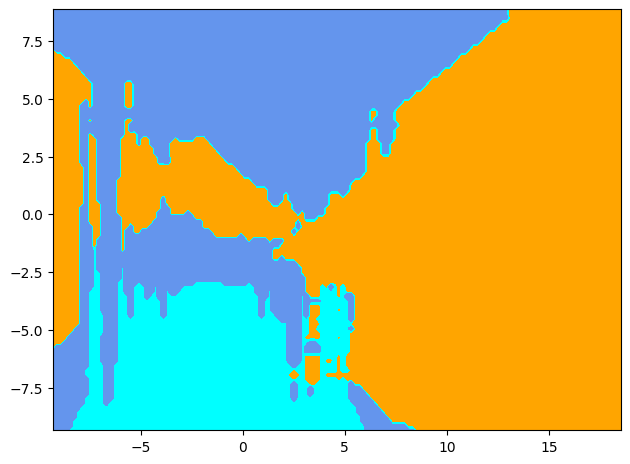

In [137]:
# Define subplots
#fig, ax = plt.subplots(4, 4, figsize = (15,15), sharex=True, sharey=True);
fig, ax = plt.subplots()
plt.tight_layout();

# Define color schemes
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue', 'red', 'green'])
cmap_bold = ['darkorange', 'c', 'darkblue']

# Step size in grid
h = 0.2

# Define different estimators and learningrates
#n_estimators = [1,10,100,100]
#learning_rate = [0.1, 0.5, 0.8, 1]

# Create a grid
x_min, x_max = X['LDA1'].min() - 1, X['LDA1'].max() + 1
y_min, y_max = X['LDA2'].min() - 1, X['LDA2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#for i, n in enumerate(n_estimators):
#    for j, l in enumerate(learning_rate):
clf = NaiveBayes(h=0.1, pdf_estimator='kde')
clf.fit(X_train_transformed, y)

# Plot decision regions
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
sns.scatterplot(x='LDA1', y="LDA2", hue=y, data=X, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax[i, j])
#ax.set_title(f"Boosting stages: {n_estimators[i]} Learning rate: {learning_rate[j]}");

<Axes: xlabel='LDA1', ylabel='LDA2'>

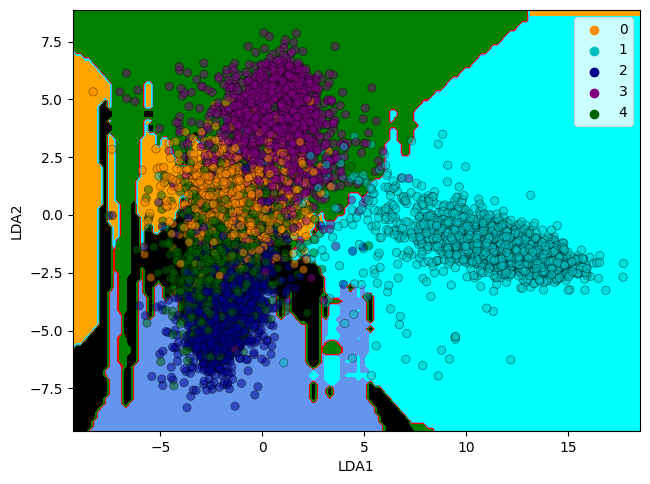

In [169]:
fig, ax = plt.subplots()
plt.tight_layout();

cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue', 'red', 'green', 'black'])
ax.contourf(xx, yy, Z, cmap=cmap_light)

cmap_bold = ['darkorange', 'c', 'darkblue', 'purple', 'darkgreen', 'black']
# Plot also the training points
sns.scatterplot(x='LDA1', y="LDA2", hue=y, data=X, palette=cmap_bold, alpha=0.5, edgecolor="black", ax=ax)
#ax.set_title(f"Boosting stages: {n_estimators[i]} Learning rate: {learning_rate[j]}");

In [167]:
Z[0]

array([4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [161]:
yy.shape

(92, 140)

In [154]:
yhat0=clf.predict(X_test_transformed[y_test==1])

In [155]:
accuracy_score(y_test[y_test==1], yhat0)

0.951